In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from keras import layers

from keras.applications import VGG16
from keras.applications import MobileNet 
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception
from keras.applications import EfficientNetB0


#from datasets import load_dataset

import pathlib


: 

In [2]:

# List all available GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        # Enable memory growth for each GPU
        # This prevents TensorFlow from allocating all GPU memory at once
        # Instead, it allocates memory dynamically as needed
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# # Load the dataset from Hugging Face
# dataset = load_dataset("Rekzi/cat-breeds", cache_dir="cat_breeds")
# print("Dataset splits:", dataset.keys())

In [3]:
data_dir = "./dataset"
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('dataset')

In [4]:
img_width = 224
img_height = 224
batch_size = 32

In [5]:
split = 0.2
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,                       # Main directory containing all class folders
    validation_split=split,           # 20% for validation
    subset="training",              # Specify we want the training subset
    seed=123,                       # For reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check the class names that were found
class_names = train_ds.class_names
print(class_names)

Found 33379 files belonging to 2 classes.
Using 26704 files for training.


I0000 00:00:1746346070.198225    5845 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2054 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 33379 files belonging to 2 classes.
Using 6675 files for validation.
['neutral', 'nsfw']


In [9]:
# WE DONT NEED TO SHOW THIS
# plt.figure(figsize=(10, 10))
# unique = []
# for images, labels in train_ds.take(1):
#   for i in range(len(images)):
#     if(class_names[labels[i]] in unique):
#       continue
#     ax = plt.subplot(1, 6, len(unique) + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")
#     unique.append(class_names[labels[i]])

In [6]:
# Collect labels from training dataset
train_labels = []
for _, y in train_ds:
    train_labels.extend(y.numpy())

# Collect labels from validation dataset
val_labels = []
for _, y in val_ds:
    val_labels.extend(y.numpy())

# Combine and analyze labels
all_train_labels = np.array(train_labels)
all_val_labels = np.array(val_labels)

2025-05-04 16:08:04.648777: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-04 16:08:07.375270: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


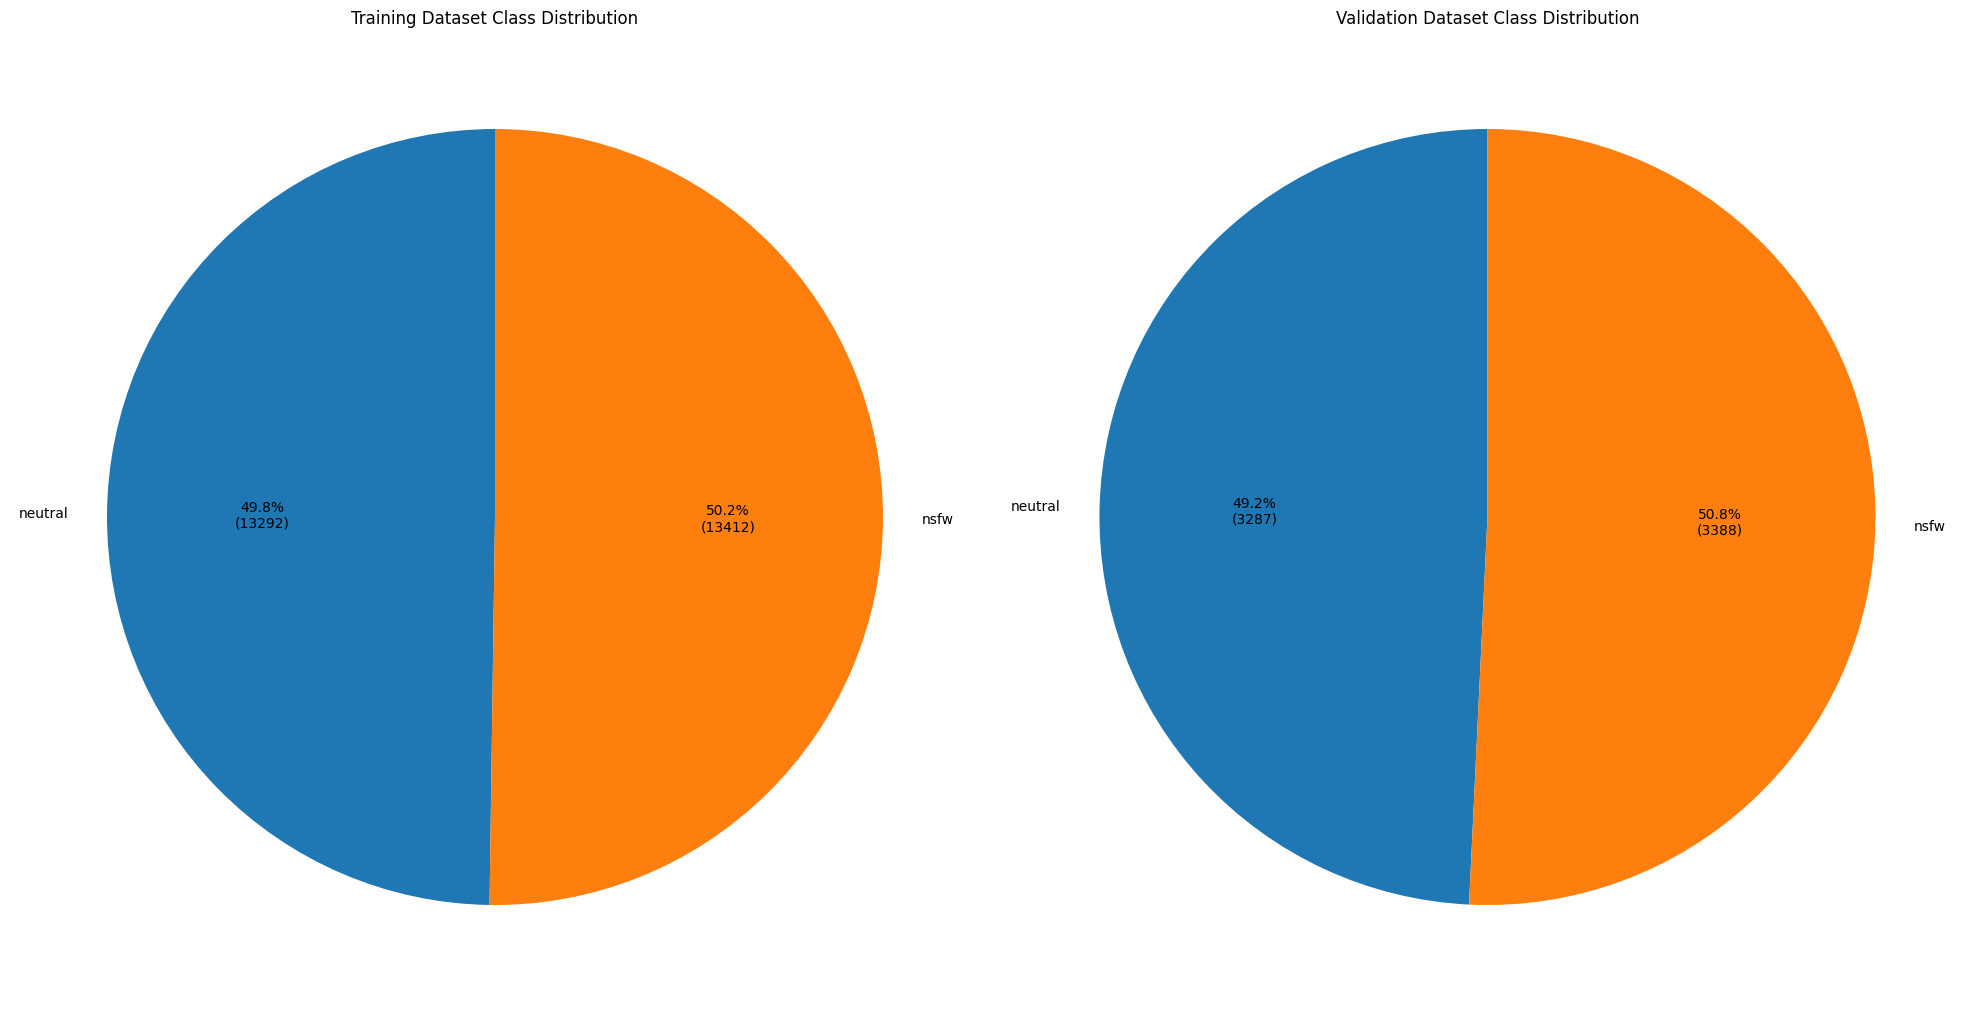

In [7]:
# Count occurrences in training dataset
train_unique_classes, train_counts = np.unique(all_train_labels, return_counts=True)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

plt.pie(train_counts, 
        labels=[class_names[i] for i in train_unique_classes], 
        autopct=make_autopct(train_counts),
        startangle=90)
plt.title('Training Dataset Class Distribution')

# Count occurrences in validation dataset
val_unique_classes, val_counts = np.unique(all_val_labels, return_counts=True)

# Subplot for validation dataset
plt.subplot(1, 2, 2)
plt.pie(val_counts, 
        labels=[class_names[i] for i in val_unique_classes], 
        autopct=make_autopct(val_counts),
        startangle=90)
plt.title('Validation Dataset Class Distribution')

plt.tight_layout()
plt.show()

In [8]:
def create_model(pre_trained_model):
    pre_trained_model.trainable = False
    
    model = tf.keras.Sequential([
        layers.Rescaling(1.0 / 255, input_shape=(img_width, img_height, 3)),
        pre_trained_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(2, activation="softmax")  # 2 classes: neutral and nsfw
    ])
    return model

In [12]:
pre = MobileNet(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

model2 = create_model(pre)

num_epochs = 5

model2.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model2.summary()

/home/kuugang/Documents/3rd Year/2ndSem/IS2/tf/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,230,914 (12.32 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # adjust if needed

history = model2.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    epochs=100, # adjust if needed
    callbacks=[
        early_stopping,
    ]
)

Epoch 1/100


2025-05-04 16:13:26.413538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2054', 4 bytes spill stores, 4 bytes spill loads

2025-05-04 16:13:26.817796: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2054', 80 bytes spill stores, 120 bytes spill loads

2025-05-04 16:13:27.225250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2054', 3160 bytes spill stores, 3164 bytes spill loads

2025-05-04 16:13:27.371090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2054', 3984 bytes spill stores, 3960 bytes spill loads



833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9171 - loss: 0.1959

2025-05-04 16:14:00.242957: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2054', 3160 bytes spill stores, 3164 bytes spill loads



835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9172 - loss: 0.1957

2025-05-04 16:14:13.560106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_686', 84 bytes spill stores, 84 bytes spill loads

2025-05-04 16:14:13.640878: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_686', 280 bytes spill stores, 332 bytes spill loads

2025-05-04 16:14:13.969448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_686', 952 bytes spill stores, 952 bytes spill loads

2025-05-04 16:14:13.983099: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_686', 1072 bytes spill stores, 1072 bytes spill loads



835/835 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.9172 - loss: 0.1957 - val_accuracy: 0.9612 - val_loss: 0.1061
Epoch 2/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.9657 - loss: 0.0939 - val_accuracy: 0.9642 - val_loss: 0.1040
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9697 - loss: 0.0839 - val_accuracy: 0.9663 - val_loss: 0.0966
Epoch 4/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9722 - loss: 0.0803 - val_accuracy: 0.9637 - val_loss: 0.1064
Epoch 5/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.9728 - loss: 0.0796 - val_accuracy: 0.9663 - val_loss: 0.1002
Epoch 6/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9728 - loss: 0.0765 - val_accuracy: 0.9639 - val_loss: 0.1045


In [14]:
model2.evaluate(val_ds)

209/209 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9621 - loss: 0.1116


[0.10452533513307571, 0.9638951420783997]

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_path = './test3_safe.jpeg'
img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
# No need to normalize here if Rescaling layer is in the model

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Get prediction
predictions = model2.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]

# Show all class probabilities
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {predictions[0][i]:.4f}")

print("Predicted class:", predicted_class_name)
print("Confidence:", predictions[0][predicted_class_index])

FileNotFoundError: [Errno 2] No such file or directory: './test4_safe.jpeg'

In [26]:
# for images, labels in val_ds.take(1):
#     first_batch_predictions = model2.predict(images)
#     first_batch_predicted_labels = np.argmax(first_batch_predictions, axis=1)
#     first_batch_true_labels = labels.numpy()
#     # print("\nPredictions on the first batch:", first_batch_predicted_labels)
#     # print("True labels of the first batch:", first_batch_true_labels)
#     plt.figure(figsize=(15, 10))
#     for i in range(len(images)):
#         true_label = class_names[labels[i].numpy()]
#         plt.subplot(2, 2, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         predicted_label = class_names[first_batch_predicted_labels[i]]
#         title_color = "green" if true_label == predicted_label else "red"
#         plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color, fontsize=10)
#         plt.axis("off")
#     plt.tight_layout()
#     plt.show()

In [34]:
import pickle

with open("class_indices.pkl", "wb") as f:
    pickle.dump({"Neutral": 0, "NSFW": 1}, f)

with open("class_indices.pkl", "rb") as f:
    pick = pickle.load(f)
    print(pick)

model2.save('nsfw.h5')

{'Neutral': 0, 'NSFW': 1}
